In [1]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

sns.set_theme(style = "dark", 
        color_codes = True,
        font_scale = 1.5)

In [2]:
def load_partition_folder(partition="train"):
    partition_folder = os.path.join(os.getcwd(),'image_csv',partition)
    

    image_indexes,images,labels = [],[],[]

    for image_fname in os.listdir(partition_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.csv',image_fname)
        image_indexes.append(image_re.group(1))
        labels.append(image_re.group(2))
        images.append(np.loadtxt(os.path.join(partition_folder,image_fname),delimiter=',',dtype=np.float32))

    image_df = pd.DataFrame({'img_index':image_indexes,'image':images,'label':labels})

    image_df["img_index"] = image_df["img_index"].astype(int)
    image_df["label"] = image_df["label"].astype(int)

    return image_df.sort_values(by="img_index").reset_index(drop=True).drop(['img_index'],axis=1)

In [3]:
train_df = load_partition_folder()
train_df.head()

,image,label
0,"[[3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 4.0,...",3
1,"[[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",1
4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10618 entries, 0 to 10617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   10618 non-null  object
 1   label   10618 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 124.6+ KB


In [4]:
test_df = load_partition_folder(partition='test')
test_df.head()

,image,label
0,"[[2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
2,"[[1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",0
3,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0
4,"[[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1405 non-null   object
 1   label   1405 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 16.6+ KB


In [5]:
X_train = train_df['image']
y_train = train_df['label']

X_test = test_df['image']
y_test = test_df['label']

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

img_shape = (240, 240, 3)
num_classes = 4

# Load pre-trained EfficientNetB0 with a different input size
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)




# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for 4 classes




# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

In [17]:
# Attempt (Base Model) - With Freeze and Unfreeze layer 
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2


# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4


# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values


# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])


# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


# Load pre-trained EfficientNetB0 with a different input size
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)


# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for 4 classes


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
history = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])


# Unfreeze some layers and fine-tune
for layer in base_model.layers[-20:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Continue training
history_fine = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded))


# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/5
332/332 [==============================] - 748s 2s/step - loss: 0.5652 - accuracy: 0.7788 - val_loss: 0.4575 - val_accuracy: 0.8085
Epoch 2/5
332/332 [==============================] - 714s 2s/step - loss: 0.3945 - accuracy: 0.8471 - val_loss: 0.3193 - val_accuracy: 0.8861
Epoch 3/5
332/332 [==============================] - 747s 2s/step - loss: 0.3436 - accuracy: 0.8701 - val_loss: 0.3142 - val_accuracy: 0.8811
Epoch 4/5
332/332 [==============================] - 717s 2s/step - loss: 0.2962 - accuracy: 0.8858 - val_loss: 0.2059 - val_accuracy: 0.9246
Epoch 5/5
332/332 [==============================] - 737s 2s/step - loss: 0.2595 - accuracy: 0.9022 - val_loss: 0.2170 - val_accuracy: 0.9260
Epoch 1/5
332/332 [==============================] - 850s 3s/step - loss: 0.3748 - accuracy: 0.8607 - val_loss: 0.2040 - val_accuracy: 0.9203
Epoch 2/5
332/332 [==============================] - 761s 2s/step - loss: 0.2120 - accuracy: 0.9194 - val_loss: 0.1399 - val_accuracy: 0.9438
Epoch 

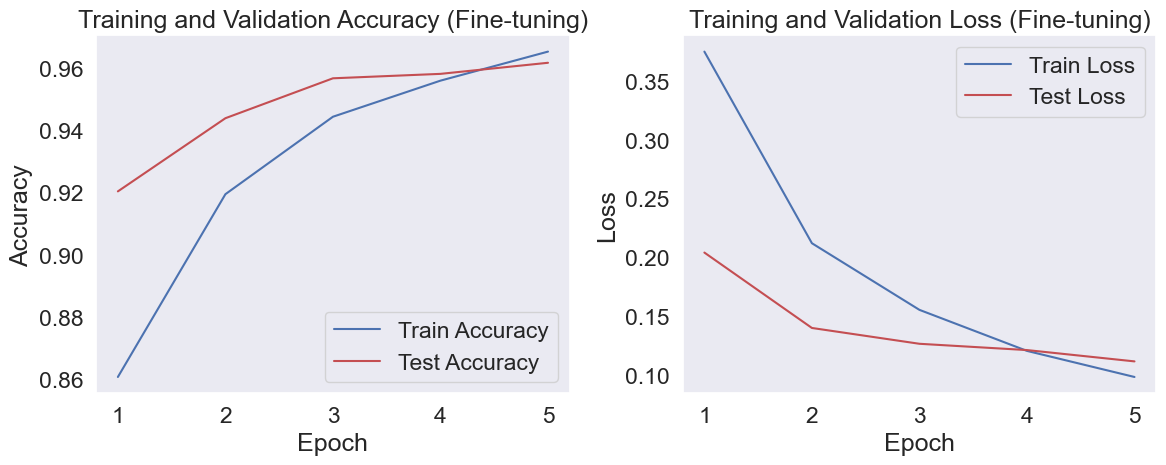

In [23]:

import matplotlib.pyplot as plt

# Extract metrics from fine-tuning history
acc2_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']
loss2_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

epochs_fine = range(1, len(acc2_fine) + 1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plotting accuracy for fine-tuning
axes[0].plot(epochs_fine, acc2_fine, 'b', label='Train Accuracy')
axes[0].plot(epochs_fine, val_acc_fine, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Training and Validation Accuracy (Fine-tuning)')

# Plotting loss for fine-tuning
axes[1].plot(epochs_fine, loss2_fine, 'b', label='Train Loss')
axes[1].plot(epochs_fine, val_loss_fine, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training and Validation Loss (Fine-tuning)')

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


In [24]:
import numpy as np
from sklearn.metrics import classification_report
# Get predictions on the test dataset
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary'])

print(report)


44/44 [==============================] - 106s 2s/step
              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       309
  meningioma       0.94      0.92      0.93       335
     notumor       1.00      0.98      0.99       399
   pituitary       0.96      0.99      0.97       362

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



In [25]:
# Tuned Model
import numpy as np
predict_x = model.predict(X_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

44/44 [==============================] - 105s 2s/step
[0 0 0 ... 3 3 3]


In [26]:
# Base model (Probably -> Need to run again)
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [27]:
# Base model (Probably -> Need to run again)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

## Tuned Model

In [6]:
# Attempt with Random Search (Benchmark to beat: 96.53%) Now: 96.87% (With Freeze and UnFreeze layers)

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import keras_tuner as kt

# Parameters
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = 4

# Example: Convert DataFrame to numpy array
X_train = np.array(train_df['image'].tolist())
y_train = train_df['label'].values
X_test = np.array(test_df['image'].tolist())
y_test = test_df['label'].values

# Ensure images have 3 channels
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_train])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.shape[-1] != 3 else img for img in X_test])

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for Keras Tuner
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Start with all layers frozen

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_tuning'
)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Initial training with all base layers frozen
model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Unfreeze the last 20 layers for fine-tuning
for layer in model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(X_train, y_train_encoded, epochs=5, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Reloading Tuner from my_dir\efficientnet_tuning\tuner0.json
Epoch 1/5
332/332 [==============================] - 717s 2s/step - loss: 0.5910 - accuracy: 0.7620 - val_loss: 0.3586 - val_accuracy: 0.8705
Epoch 2/5
332/332 [==============================] - 693s 2s/step - loss: 0.4263 - accuracy: 0.8364 - val_loss: 0.3829 - val_accuracy: 0.8477
Epoch 3/5
332/332 [==============================] - 684s 2s/step - loss: 0.3651 - accuracy: 0.8596 - val_loss: 0.2924 - val_accuracy: 0.8875
Epoch 4/5
332/332 [==============================] - 695s 2s/step - loss: 0.3272 - accuracy: 0.8727 - val_loss: 0.2241 - val_accuracy: 0.9224
Epoch 5/5
332/332 [==============================] - 684s 2s/step - loss: 0.3072 - accuracy: 0.8826 - val_loss: 0.2460 - val_accuracy: 0.9039
Epoch 1/5
332/332 [==============================] - 824s 2s/step - loss: 0.3745 - accuracy: 0.8552 - val_loss: 0.2005 - val_accuracy: 0.9253
Epoch 2/5
332/332 [==============================] - 782s 2s/step - loss: 0.2230 - accur

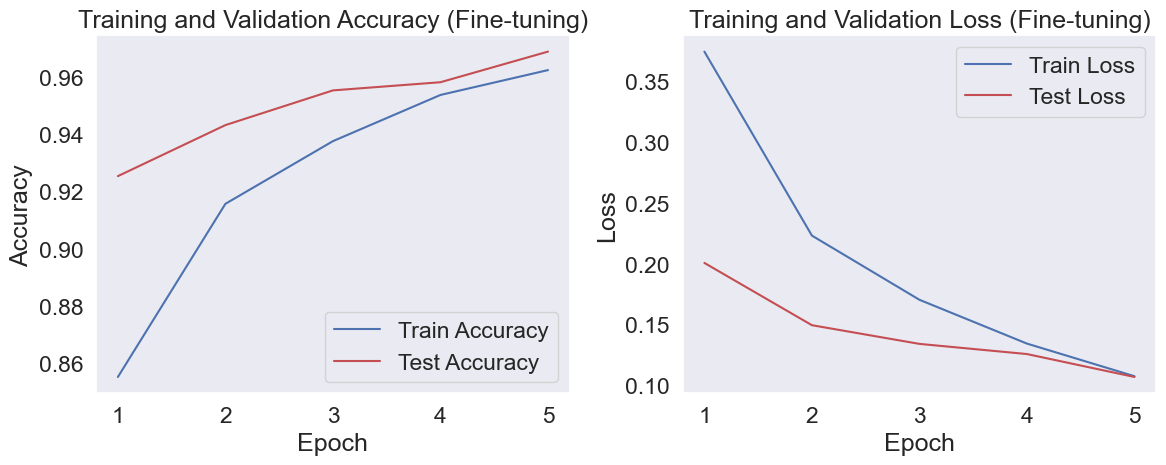

In [9]:
import matplotlib.pyplot as plt

# Extract metrics from fine-tuning history
acc2_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']
loss2_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

epochs_fine = range(1, len(acc2_fine) + 1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plotting accuracy for fine-tuning
axes[0].plot(epochs_fine, acc2_fine, 'b', label='Train Accuracy')
axes[0].plot(epochs_fine, val_acc_fine, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Training and Validation Accuracy (Fine-tuning)')

# Plotting loss for fine-tuning
axes[1].plot(epochs_fine, loss2_fine, 'b', label='Train Loss')
axes[1].plot(epochs_fine, val_loss_fine, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training and Validation Loss (Fine-tuning)')

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()


In [14]:
# Tuned Model
import numpy as np
from sklearn.metrics import classification_report

# Get predictions on the test dataset
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary'])

print(report)


44/44 [==============================] - 97s 2s/step
              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       309
  meningioma       0.94      0.96      0.95       335
     notumor       1.00      0.98      0.99       399
   pituitary       0.96      0.99      0.97       362

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405



In [11]:
# Tuned Model
import numpy as np
predict_x = model.predict(X_test)
predict1 = np.argmax(predict_x, axis = 1)
print(predict1)

44/44 [==============================] - 82s 2s/step
[0 0 0 ... 3 3 3]


In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 2048, 'step': 256, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [13]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:")
print(f"Units in dense layer: {best_hps.get('units')}")
print(f"Dropout rate: {best_hps.get('dropout')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Best hyperparameters:
Units in dense layer: 1024
Dropout rate: 0.2
Learning rate: 0.001


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['normalization[0][0]']      